In [1]:
import numpy as np
import pandas as pd
from ase.io.xyz import read_xyz
from ase.io import read
from io import StringIO
import os
import schnetpack as spk
from torch.optim import Adam
import matplotlib.pyplot as plt
import schnetpack.train as trn
from schnetpack import AtomsData
import torch
from sklearn.model_selection import KFold

In [2]:
freesolv_file = '../../data/FreeSolv_with_3D.csv'
freesolv_data = pd.read_csv(freesolv_file)

In [3]:
freesolvmod = "./FreeSolvModel"
if not os.path.exists('FreeSolvModel'):
    os.makedirs(freesolvmod)

In [4]:
atoms = freesolv_data['xyz'].map(lambda x: next(read_xyz(StringIO(x), slice(None))))
atoms = [a for a in atoms]

In [5]:
freesolv_expt = np.array(freesolv_data["expt"],dtype=float)

In [6]:
property_list = []
for f in freesolv_expt:
    
    property_list.append(
        {'expt': float(f)}
    )

print('Properties:', property_list)

Properties: [{'expt': -11.01}, {'expt': -4.87}, {'expt': 1.83}, {'expt': -5.45}, {'expt': -4.21}, {'expt': -6.27}, {'expt': 2.34}, {'expt': -3.92}, {'expt': 1.58}, {'expt': -4.62}, {'expt': -1.96}, {'expt': -3.88}, {'expt': -4.33}, {'expt': -2.49}, {'expt': -2.55}, {'expt': -4.78}, {'expt': -1.46}, {'expt': -2.22}, {'expt': -5.85}, {'expt': 2.88}, {'expt': -6.34}, {'expt': -6.1}, {'expt': -5.48}, {'expt': -4.1}, {'expt': -4.1}, {'expt': -3.52}, {'expt': -4.47}, {'expt': -2.74}, {'expt': -3.43}, {'expt': -7.81}, {'expt': -0.8}, {'expt': 0.93}, {'expt': -6.78}, {'expt': -9.29}, {'expt': -4.07}, {'expt': -5.91}, {'expt': -2.13}, {'expt': -3.64}, {'expt': -2.68}, {'expt': 3.13}, {'expt': -10.0}, {'expt': 2.06}, {'expt': -8.11}, {'expt': -1.12}, {'expt': -23.62}, {'expt': -2.83}, {'expt': -4.68}, {'expt': -5.56}, {'expt': -3.65}, {'expt': -5.49}, {'expt': 3.12}, {'expt': -4.42}, {'expt': -6.2}, {'expt': -6.96}, {'expt': -0.16}, {'expt': -0.25}, {'expt': -9.3}, {'expt': -4.63}, {'expt': -10.

In [7]:
%rm 'FreeSolvModel/FreeSolv_SchNet_dataset.db'
new_dataset = AtomsData(os.path.join(freesolvmod, 'FreeSolv_SchNet_dataset.db'), available_properties=['expt'])
new_dataset.add_systems(atoms, property_list)

In [8]:
print('Number of reference calculations:', len(new_dataset))
print('Available properties:')

for p in new_dataset.available_properties:
    print('-', p)
print()

example = new_dataset[0]
print('Properties of molecule with id 0:')

for k, v in example.items():
    print('-', k, ':', v.shape)

Number of reference calculations: 642
Available properties:
- expt

Properties of molecule with id 0:
- expt : torch.Size([1])
- _atomic_numbers : torch.Size([26])
- _positions : torch.Size([26, 3])
- _neighbors : torch.Size([26, 25])
- _cell : torch.Size([3, 3])
- _cell_offset : torch.Size([26, 25, 3])
- _idx : torch.Size([1])


In [9]:
train, val, test = spk.train_test_split(
        data=new_dataset,
        num_train=400,
        num_val=100,
        split_file=None#os.path.join(freesolvmod, "freesolv_split.npz"),
    )

In [10]:
train_loader = spk.AtomsLoader(train, batch_size=32, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=32)

In [11]:
schnet = spk.representation.SchNet(
    n_atom_basis=30, n_filters=30, n_gaussians=20, n_interactions=5,
    cutoff=4., cutoff_network=spk.nn.cutoff.CosineCutoff
)

In [12]:
output = spk.atomistic.Atomwise(n_in=30, property='expt')

model = spk.AtomisticModel(representation=schnet, output_modules=output)

In [13]:
optimizer = Adam(model.parameters(), lr=1e-2)

In [14]:
loss = trn.build_mse_loss(['expt'])

metrics = [spk.metrics.MeanAbsoluteError('expt')]

hooks = [
    trn.CSVHook(log_path=freesolvmod, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=5, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]

trainer = trn.Trainer(
    model_path=freesolvmod,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

In [15]:
%%time
device = "cpu" # change to 'cpu' if gpu is not available, change to cuda if gpu is
n_epochs = 100 # takes about 10 min on a notebook GPU. reduces for playing around

print('training...')
trainer.train(device=device, n_epochs=n_epochs)
print('Complted.')

training...
Complted.
CPU times: user 7min 10s, sys: 7.86 s, total: 7min 18s
Wall time: 4min 14s


Final validation MAE: 0.814


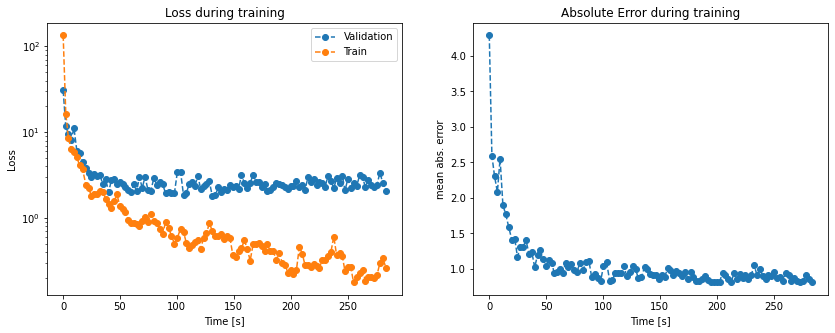

In [16]:
results = np.loadtxt(os.path.join('FreeSolvModel', 'log.csv'), skiprows=1, delimiter=',')

time = results[:,0]-results[0,0]
learning_rate = results[:,1]
train_loss = results[:,2]
val_loss = results[:,3]
val_mae = results[:,4]

print('Final validation MAE:', np.round(val_mae[-1], 3))

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(time, val_loss, '--o', label='Validation')
plt.plot(time, train_loss, '--o', label='Train')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Time [s]')
plt.legend()
plt.title('Loss during training')

plt.subplot(1,2,2)
plt.plot(time, val_mae, '--o')
plt.ylabel('mean abs. error')
plt.xlabel('Time [s]')
plt.title('Absolute Error during training')
plt.show()

In [17]:
val_mae[-1]

0.8141097354888917

In [18]:
results_path = "./FreeSolvModel"

best_model = torch.load(os.path.join(results_path, 'best_model'))

#train, val, test = spk.train_test_split(
#        data=new_dataset,
#        split_file=os.path.join(freesolvmod, "split.npz"),
#    )

test_loader = spk.AtomsLoader(test, batch_size=32)

err = 0
rmse = 0

actual_vals = []
batch_preds = []
for count, batch in enumerate(test_loader):
    # move batch to GPU, if necessary
    batch = {k: v.to(device) for k, v in batch.items()}

    # apply model
    pred = best_model(batch)
#     print(pred['expt'].detach().cpu().numpy().shape)
    actual_vals += list(np.squeeze(batch['expt'].detach().cpu().numpy()))
    batch_preds += list(np.squeeze(pred['expt'].detach().cpu().numpy()))

    # calculate absolute error
    tmp = torch.sum(torch.abs(pred['expt']-batch['expt']))
    tmp = tmp.detach().cpu().numpy() # detach from graph & convert to numpy
    err += tmp
    
    # calculate RMSE:
    tmp2 = torch.sum(torch.square(pred['expt']-batch['expt']))
    tmp2 = tmp2.detach().cpu().numpy() # detach from graph & convert to numpy
    rmse += tmp2

    # log progress
    percent = '{:3.2f}'.format(count/len(test_loader)*100)
    print('Progress:', percent+'%'+' '*(5-len(percent)), end="\r")

err /= len(test)
rmse /= len(test)
rmse = np.sqrt(rmse)
print('Test MAE', np.round(err, 10))
print('Test RMSE', np.round(rmse, 10))

Test MAE 0.8581976219
Test RMSE 1.301941557


In [19]:
actual_vals = np.array(actual_vals)
batch_preds = np.array(batch_preds)

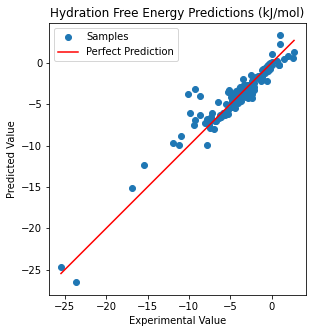

In [20]:
x_vec = np.linspace(actual_vals.min(), actual_vals.max(), 100)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(actual_vals, batch_preds, 'o', label='Samples')
ax.plot(x_vec, x_vec, 'red', label='Perfect Prediction')
ax.set_xlabel("Experimental Value")
ax.set_ylabel("Predicted Value")
ax.set_aspect('equal')
ax.legend()
plt.title('Hydration Free Energy Predictions (kJ/mol)')
plt.show()